In [1]:
from __future__ import absolute_import
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
from glob import glob
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
import os

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
trainlabel = pd.read_csv('../Data/train.csv')

In [28]:
batch_size = 32
nb_classes = 447
nb_epoch = 2
data_augmentation = True

In [4]:
# shape of the image (SHAPE x SHAPE)
shapex, shapey = 64, 64
# number of convolutional filters to use at each layer
nb_filters = 32
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = 2
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = 3
# the MNIST images are greyscale
image_dimensions = 3

In [5]:
#dloc = '../../BigData/kaggle-right-whale/imgs/'
dloc = '../Data/headshots/'
features = []
#features_test = []
foundlist = []
#foundlist_test = []
files = glob(dloc + '*.jpg')
for ifile in files:
    filesplit = os.path.splitext(ifile)
    #endindex = ifile.index('_small')
    #startindex = ifile.index('w_')
    imlocstart = ifile.index('w_')
    imloc = ifile[imlocstart:]
    imdata = imread(ifile)
    ny, nx = imdata[:, :, 0].shape
    tmp = np.zeros((3, 64, 64))
    if nx != 64 or ny != 64:
        for i in range(3):
            tmp[i, :, :] = resize(imdata[:, :, i], (64, 64))
    else:
        for i in range(3):
            tmp[i, :, :] = imdata[:, :, i]
    imdata = tmp
    #print(imloc)
    if imloc in trainlabel['Image'].values:
        #print('Found ' + imloc + ' in train set.')
        #print(imdata.transpose().shape)
        features.append(imdata)
        trainlabelindex = trainlabel['Image'].values == imloc
        trainlabelvalue = trainlabel['whaleID'].values[trainlabelindex][0]
        foundlist.append(trainlabelvalue)
        #import pdb; pdb.set_trace()
    else:
        #print('Found ' + imloc + ' in test set.')
        import pdb; pdb.set_trace()
        features_test.append(imdata)
        foundlist_test.append(imloc)

In [6]:
len(files)

4536

In [7]:
#dloc = '../../BigData/kaggle-right-whale/imgs/'
dloc = '../Data/headshots/test/'
features_test = []
foundlist_test = []
files = glob(dloc + '*.jpg')
for ifile in files:
    filesplit = os.path.splitext(ifile)
    #endindex = ifile.index('_small')
    #startindex = ifile.index('w_')
    imlocstart = ifile.index('w_')
    imloc = ifile[imlocstart:]
    imdata = imread(ifile)
    ny, nx = imdata[:, :, 0].shape
    tmp = np.zeros((3, 64, 64))
    if nx != 64 or ny != 64:
        for i in range(3):
            tmp[i, :, :] = resize(imdata[:, :, i], (64, 64))
    else:
        for i in range(3):
            tmp[i, :, :] = imdata[:, :, i]
    imdata = tmp
    #print(imloc)
    if imloc in trainlabel['Image'].values:
        print('Found ' + imloc + ' in train set.')
        #print(imdata.transpose().shape)
        import pdb; pdb.set_trace()
        #features.append(imdata)
        #trainlabelindex = trainlabel['Image'].values == imloc
        #trainlabelvalue = trainlabel['whaleID'].values[trainlabelindex][0]
        #foundlist.append(trainlabelvalue)
    else:
        #print('Found ' + imloc + ' in test set.')
        #import pdb; pdb.set_trace()
        features_test.append(imdata)
        foundlist_test.append(imloc)

In [8]:
features_test = np.array(features_test)

In [9]:
features = np.array(features)

In [23]:
features.shape

(4536, 3, 64, 64)

In [24]:
features_test.shape

(6917, 3, 64, 64)

In [12]:
vectorizer = CountVectorizer(min_df=1)

In [34]:
X = features
y = vectorizer.fit_transform(foundlist).toarray()

<matplotlib.colorbar.Colorbar instance at 0x130a843b0>

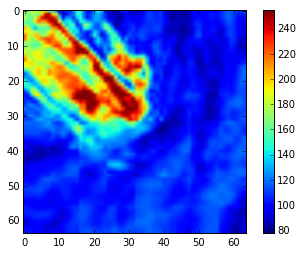

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[11, 0, :, :])
plt.colorbar()

In [36]:
# the data, shuffled and split between tran and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (3175, 3, 64, 64)
3175 train samples
1361 test samples


In [27]:
y.shape

(4536, 447)

### Adapted from MNIST example

In [37]:
model = Sequential()

model.add(Convolution2D(nb_filters, 3, nb_conv, nb_conv, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
# the resulting image after conv and pooling is the original shape
# divided by the pooling with a number of filters for each "pixel"
# (the number of filters is determined by the last Conv2D)
model.add(Dense(nb_filters * (shapex / nb_pool) * (shapey / nb_pool), 1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, nb_classes))
model.add(Activation('softmax'))

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [39]:
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 3175 samples, validate on 1361 samples
Epoch 0
3175/3175 [==============================] - 591s - loss: 19.7757 - acc: 0.0028 - val_loss: 6.1330 - val_acc: 0.0029
Epoch 1
3175/3175 [==============================] - 587s - loss: 6.0910 - acc: 0.0076 - val_loss: 6.0664 - val_acc: 0.0096
Test score: 6.06637012257
Test accuracy: 0.00955180014695


In [40]:
ok = model.predict(features_test)

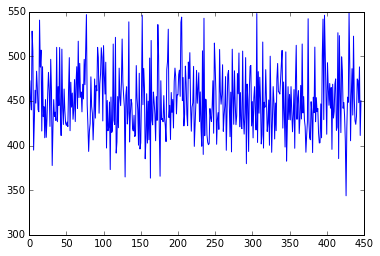

In [54]:
plt.plot(1/ok[3100])

### Adapted from CIFAR10 example

In [92]:
model = Sequential()

In [93]:
model.add(Convolution2D(nb_filters[0], image_dimensions, nb_conv[0], nb_conv[0], border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters[0], nb_filters[0], nb_conv[0], nb_conv[0]))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(nb_pool[0], nb_pool[0])))
model.add(Dropout(0.25))

In [94]:
model.add(Convolution2D(nb_filters[1], nb_filters[0], nb_conv[0], nb_conv[0], border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters[1], nb_filters[1], nb_conv[1], nb_conv[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(nb_pool[1], nb_pool[1])))
model.add(Dropout(0.25))

In [95]:
model.add(Flatten())

In [96]:
# the image dimensions are the original dimensions divided by any pooling
# each pixel has a number of filters, determined by the last Convolution2D layer
model.add(Dense(nb_filters[-1] * (shapex / nb_pool[0] / nb_pool[1]) * (shapey / nb_pool[0] / nb_pool[1]), 512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

In [97]:
model.add(Dense(512, nb_classes))
model.add(Activation('softmax'))

In [98]:
# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

In [100]:
data_augmentation

True

In [ ]:
if not data_augmentation:
    print("Not using data augmentation or normalization")

    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")
    X_train /= 255
    X_test /= 255
    model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True)
    score = model.evaluate(X_test, y_test, batch_size=batch_size)
    print('Test score:', score)

else:
    print("Using real time data augmentation")

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)

    for e in range(nb_epoch):
        print('-'*40)
        print('Epoch', e)
        print('-'*40)
        print("Training...")
        # batch train with realtime data augmentation
        progbar = generic_utils.Progbar(X_train.shape[0])
        for X_batch, y_batch in datagen.flow(X_train, y_train):
            loss = model.train_on_batch(X_batch, y_batch)
            progbar.add(X_batch.shape[0], values=[("train loss", loss)])

        print("Testing...")
        # test time!
        progbar = generic_utils.Progbar(X_test.shape[0])
        for X_batch, y_batch in datagen.flow(X_test, y_test):
            score = model.test_on_batch(X_batch, y_batch)
            progbar.add(X_batch.shape[0], values=[("test loss", score)])

Using real time data augmentation
----------------------------------------
Epoch 0
----------------------------------------
Training...
 800/3180 [======>.......................] - ETA: 14587s - train loss: 6.1506

In [46]:
test_image = features_test

In [47]:
ypredict = model.predict(test_image, batch_size=batch_size)

In [48]:
dfpredict = pd.DataFrame(ypredict)

In [59]:
dfpredict.shape

(6924, 447)

In [60]:
sample_submission = pd.read_csv('../Data/sample_submission.csv')

In [63]:
dfpredict.columns = sample_submission.columns[1:]

In [70]:
dfpredict['Image'] = foundlist_test
dfpredict.to_csv('../Data/predict_CNNbenchmark.csv', index=False)

In [71]:
sample_submission.shape

(6925, 448)

In [72]:
dfpredict.shape

(6924, 448)

In [74]:
len(files)

11468